In [120]:
import torch
from torch import nn 
import matplotlib.pyplot as plt

print(torch.__version__)

2.5.1


# Prepare data

In [121]:
#create my own data
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias


X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [122]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [123]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions = None):
    """Plot training data, test data and compares predictions"""

    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c='b', s=4, label = "Training data")

    plt.scatter(test_data, test_labels, c='g', s=4, label= "Tesing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")


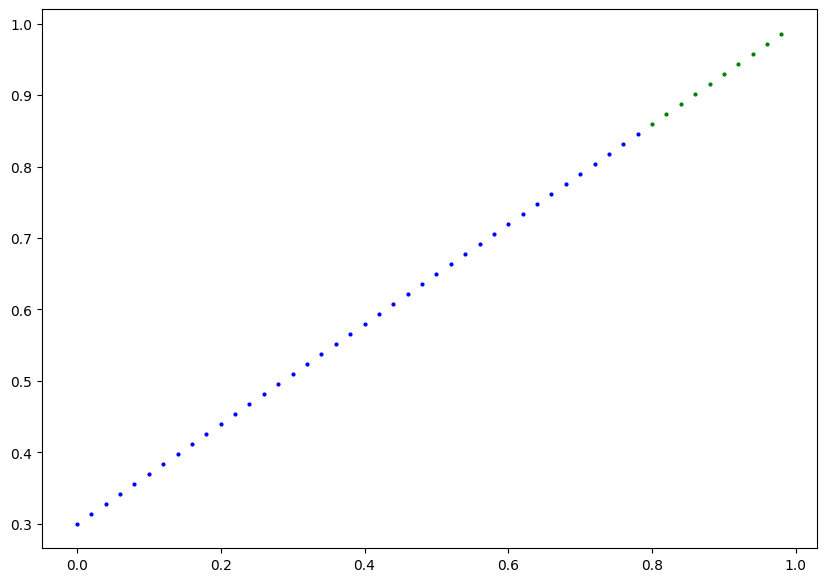

In [124]:
plot_predictions(X_train, y_train, X_test, y_test)

# Build Model

In [125]:
class LinearRegressionModel(nn.Module):
    def __init__(self, *args, **kwargs):# <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
        super().__init__(*args, **kwargs)
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)# <- start with random weights (this will get adjusted as the model learns)
        #  <- PyTorch loves float32 by default
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)
    

In [126]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [127]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [128]:
with torch.inference_mode(): #this is newer than torch.no_grad()
    y_preds = model_0(X_test)


In [129]:
len(X_test), len(y_preds)

(10, 10)

In [130]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

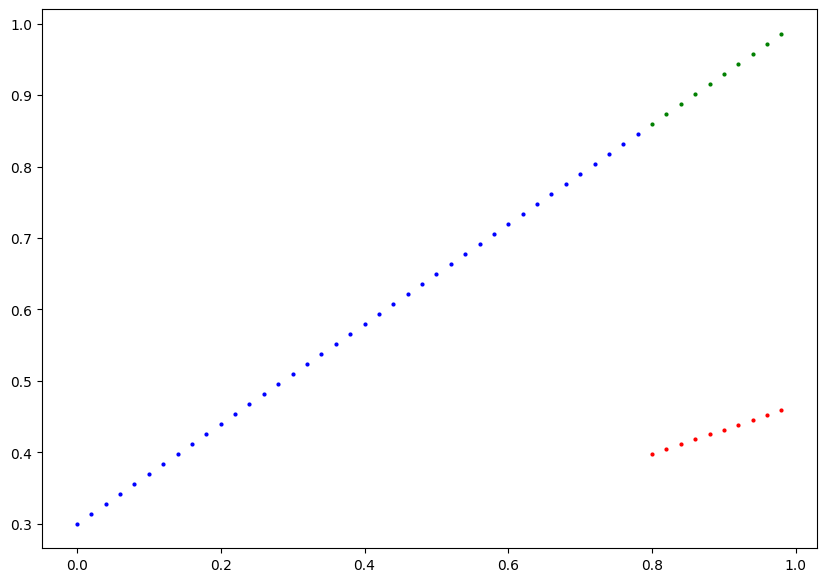

In [131]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

In [132]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

# Train a model

In [133]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)



## Train steps

| Number | Step name | What does it do? | Code example |
|:--:|:--|:--|:--|
| **1** | **Forward pass** | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| **2** | **Calculate the loss** | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` |
| **3** | **Zero gradients** | The optimizer’s gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| **4** | **Perform backpropagation on the loss** | Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence “backwards.” | `loss.backward()` |
| **5** | **Update the optimizer (gradient descent)** | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |


## Test steps

| Number | Step name | What does it do? | Code example |
|:--:|:--|:--|:--|
| **1** | **Forward pass** | The model goes through all of the testing data once, performing its `forward()` function calculations. | `model(x_test)` |
| **2** | **Calculate the loss** | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` |
| **3** | **Calculate evaluation metrics (optional)** | Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |


In [134]:
torch.manual_seed(42)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # put the model in training mode (this is the default state of a model)

    ## training 
    model_0.train()

    y_pred = model_0(X_train)

    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad() #reset the grad of the optimizer

    loss.backward() # calculate the gradient of each parameters

    optimizer.step() # update the optimizer

    ## testing

    #put the model in evalutation mode

    model_0.eval()

    with torch.inference_mode():
        test_pred = model_0(X_test)

        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy()) #detach() : remove gradient tracking
            test_loss_values.append(test_loss.detach().numpy()) #numpy(): converts to Numpy array
            print(f'epoch: {epoch} | MAE Train loss: {loss} | MAE Test Loss: {test_loss} ')


epoch: 0 | MAE Train loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
epoch: 10 | MAE Train loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
epoch: 20 | MAE Train loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
epoch: 30 | MAE Train loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
epoch: 40 | MAE Train loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
epoch: 50 | MAE Train loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
epoch: 60 | MAE Train loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
epoch: 70 | MAE Train loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
epoch: 80 | MAE Train loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
epoch: 90 | MAE Train loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


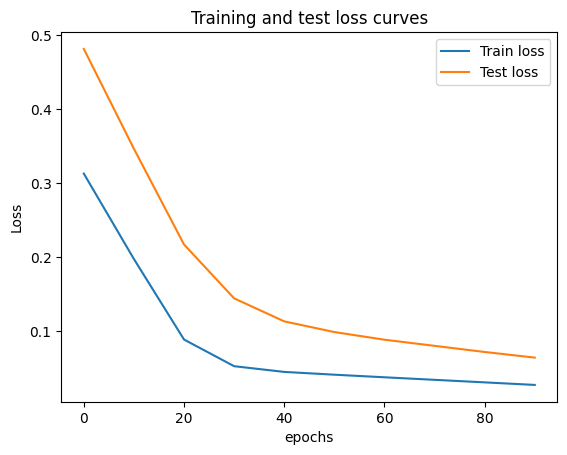

In [135]:
plt.plot(epoch_count, train_loss_values, label= "Train loss")
plt.plot(epoch_count, test_loss_values, label= "Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [136]:
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("original parameters: ")
print(f'w: {weight}, b: {bias}')

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])
original parameters: 
w: 0.7, b: 0.3


# Making predictions with a trained PyTorch model (inference)

In [137]:
model_0.eval()

with torch.inference_mode():

    y_preds = model_0(X_test)

y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

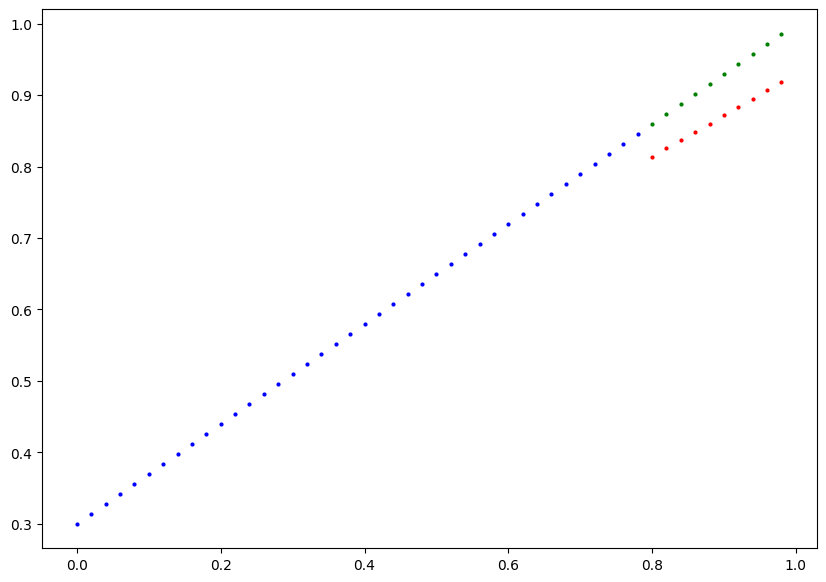

In [138]:
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

# Saving and loading a pytorch model

| **PyTorch method** | **What does it do?** |
|---------------------|----------------------|
| `torch.save` | Saves a serialized object to disk using Python's `pickle` utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`. |
| `torch.load` | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| `torch.nn.Module.load_state_dict` | Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. |


In [139]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents= True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"saving model to: {MODEL_SAVE_PATH}")

torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

saving model to: models/01_pytorch_workflow_model_0.pth


In [140]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))

<All keys matched successfully>

In [141]:
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [142]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Put it all together

In [143]:
weight = 0.7
bias = 0.3

X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight * X + bias 
X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [144]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

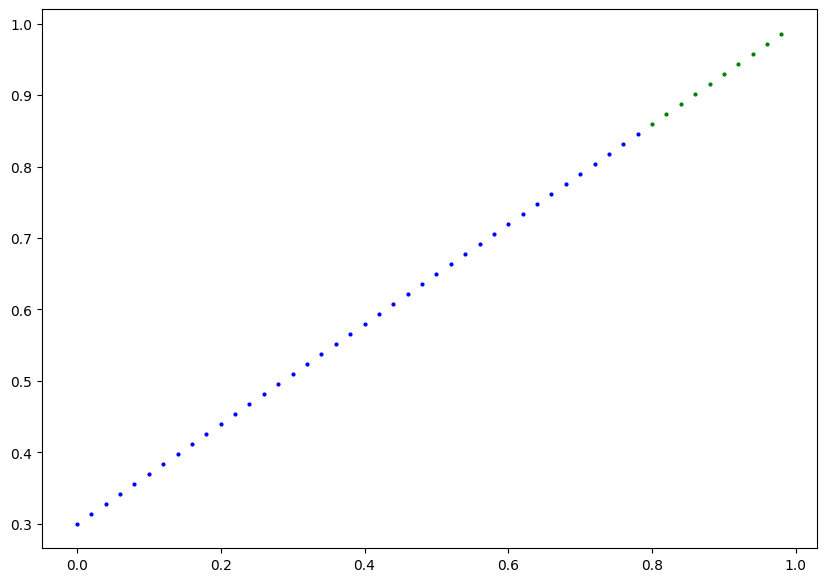

In [145]:
plot_predictions(X_train, y_train, X_test, y_test)

In [146]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [147]:
next(model_1.parameters()).device

device(type='cpu')

In [148]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [149]:
# Set model to GPU if it's available, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cpu')

In [150]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [151]:
torch.manual_seed(42)

epochs = 1000
for epoch in range(epochs):
    model_1.train()

    y_pred = model_1(X_train)

    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f'epoch: {epoch}, | Train loss: {loss} | Test loss: {test_loss}')


epoch: 0, | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
epoch: 100, | Train loss: 0.006215679459273815 | Test loss: 0.014086711220443249
epoch: 200, | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
epoch: 300, | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
epoch: 400, | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
epoch: 500, | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
epoch: 600, | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
epoch: 700, | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
epoch: 800, | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
epoch: 900, | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904


In [152]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3
